<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Examples.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>

# Examples: Improving a logistic regression model
© ExploreAI Academy

In this train, we'll rebuild and evaluate logistic regression models through performance metrics to enhance prediction accuracy.

## Learning objectives

By the end of this train, you should be able to:
- Rebuild a logistic regression model for improved accuracy.
- Assess model performance accurately using the confusion matrix and classification report.
- Understand the evaluation of binary classifiers, particularly in the context of class imbalance, and become familiar with metrics such as accuracy, precision, recall, and F1 score.

## Examples

This train is structured as follows:

1. Rebuild our Wisconsin Breast Cancer classifier.
2. Use feature subset selection to create a sparse model.
3. Tune the logistic regression model hyperparameter.

### Example 1: Rebuilding the Breast Cancer classifier

Let's explore the potential of logistic regression in diagnosing breast cancer, utilising the **Wisconsin Breast Cancer dataset**. This dataset includes 30 continuous features and a binary target indicating tumour malignancy. Our aim is to enhance model precision in distinguishing between benign (1) and malignant (0) cases.

We'll start by making the necessary imports:

* `numpy` for numerical operations.
* `pandas` for data manipulation.
* `matplotlib` for plotting graphs.  
* `%matplotlib inline` to ensure that plots are displayed inline within the notebook. 
* `load_breast_cancer` function provides access to the Wisconsin Breast Cancer dataset.
* `classification_report` function for assessing the performance of classification models by providing key metrics such as precision, recall, F1 score, and accuracy for each class. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Import dataset
from sklearn.datasets import load_breast_cancer

# For precision, recall, etc.
from sklearn.metrics import classification_report

We'll then load the breast cancer dataset by calling the `load_breast_cancer` function with the parameter `return_X_y=True`. This instructs the function to return the dataset split into features and target variables, which are assigned to `X` and `y`, respectively. 

In [2]:
X, y = load_breast_cancer(return_X_y=True)

Remember to perform data scaling of the data during preprocessing for all machine learning tasks as _scaling_ puts all our features into the same range.

In [3]:
# Import the scaler module
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

# Scale data
X_scaled = scaler.fit_transform(X)

We can now split the scaled features `X_scaled` and target `y` into training and testing sets. We'll reserve 20% of the data for testing (`test_size=0.2`) and ensure reproducibility by setting a `random_state`. 

In [4]:
from sklearn.model_selection import train_test_split

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=10)

In [5]:
from sklearn.linear_model import LogisticRegression

### Example 2: Using feature subset selection to create a sparse model

In general, given a particular model and a dataset, there are two categories of change we can make to try and improve the model once it has been trained with default parameters:

1. We can change/reduce which features the model was trained on.
2. We can tweak what are known as model hyperparameters.

For both methods, the benchmark performance metrics we will use (within classification tasks) are precision, recall, and F1 score. In other words, after making our changes, we will compare the results for each of those metrics to the default model to determine if an improvement has been made.

We'll start with the first method and change which features the model is trained on. Assuming the default model was trained using all the features, any change we undertake will invariably reduce the number of features we use. A model trained using some subset of all the available features is known as a _sparse model_.

We'll create four models to compare. In so doing, we'll cover some of the feature subset selection methods available for classification that you may be able to use in the course and your career going forward:

1. Full model – using all features (reference model).
2. Variance thresholding.
3. Select k-best features.
4. Sequential forward selection.

An important note here: Always split your dataset into train/test folds _before_ performing feature selection. This prevents what is known as data leakage, where some of the 'unseen' data are exposed to the model during the training process, which would in turn inflate its test set accuracy later on. Take a quick read through the [tweet below](https://twitter.com/jmschreiber91/status/1137464236156702720?s=20) for some more context.

<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/split-tweet.jpg" alt="train/test split ordering tweet" width="400px;">

For each method, we'll perform the feature selection on both the train and test sets – ensuring the model is tested on data with the same features it was trained on.

#### 1. Full model (no selection)

In order to have a reference model, we'll build a logistic regression classifier using all the features.

In [6]:
lm_full = LogisticRegression()

We'll need to standardise our features here to ensure the model is able to converge.

In [7]:
# No transformations necessary
lm_full.fit(X_train, y_train)

LogisticRegression()

In [8]:
# Generate predictions from full model
pred_lm_full = lm_full.predict(X_test)

#### 2. Selection by variance thresholding

As you may recall, variance thresholding is a process by which we remove features which don't meet some minimum level of variance.

<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/sketch-var-thresh.png" alt="sketch-var-thresh" width="500px;"/>

In [9]:
# lm instance for var thresh
lm_vt = LogisticRegression()

When we apply the transformation (i.e. run feature selection) on the training set, we are fitting the transformation: `fit_transform(train_data)`. In order to apply the same transformation to the test set, we only need to transform it, not fit it: `transform(test_data)`.

In [10]:
# Import the var thresh model and choose a threshold
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.02)

# Transform (i.e.: run selection on) the training data
X_train_vt = selector.fit_transform(X_train)

In [11]:
X_train_vt.shape

(455, 15)

Using a variance threshold of 0.02, we have managed to trim the number of features in the training dataset from 30 down to 15.

In [12]:
# Fit model to the transformed data
lm_vt.fit(X_train_vt, y_train)

LogisticRegression()

In [13]:
# Now we'll need to remove the same features we did in the thresholding process
X_test_vt = selector.transform(X_test)

# Generate predictions from var thresh model
pred_lm_vt = lm_vt.predict(X_test_vt)

#### 3. Selection by choosing k-best features

`SelectKBest` is a feature selection module in `sklearn` which removes all but the _k_ highest scoring features according to some specified statistical test. In this case, we'll use `f_classif` as the test, which we specify in the `score_func` argument in the `SelectKBest` method.

`f_classif` computes the ANOVA f-value between each label and feature – read up [more on it here](https://www.statisticshowto.com/probability-and-statistics/f-statistic-value-test/).

<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/sketch-kbest.png" alt="sketch-kbest" width="600px;"/>

In [14]:
# lm instance for k-best
lm_kbest = LogisticRegression()

In [15]:
# Import the feature selector module
from sklearn import feature_selection
from sklearn.feature_selection import f_classif

# Set up selector, choosing score function and number of features to retain
selector_kbest = feature_selection.SelectKBest(score_func=f_classif, k=20,)

# Transform (i.e.: run selection on) the training data
X_train_kbest = selector_kbest.fit_transform(X_train, y_train)

In [16]:
X_train_kbest.shape

(455, 20)

In [17]:
# Fit model to the transformed data
lm_kbest.fit(X_train_kbest, y_train)

LogisticRegression()

In [18]:
# Before generating predictions, we'll need to transform the test data the same way we did the train data
X_test_kbest = selector_kbest.transform(X_test)

# Generate predictions from var thresh model
pred_lm_kbest = lm_kbest.predict(X_test_kbest)

#### 4. Selection using sequential forward selection

In this process, we iteratively fit the logistic regression classifier to our dataset, where our dataset starts with one feature and adds one feature per iteration. For each iteration, k-fold cross-validation is used to compute the performance of the classifier. Thereafter, we can determine which number of features resulted in the optimal performance.

| 🚩 **Note** 🚩 |
| : ----------------------- :|
| We'll be using the `SequentialFeatureSelector` from a library known as `mlxtend`. **Be sure to: "`pip install mlxtend`" before you run the code below**. We'll also be using F1 score to compute the performance of each fitted model. |



<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/sketch-sfs.png" alt="sketch-sfs" width="700px;">

In [20]:
!poetry add mlxtend

The following packages are already present in the pyproject.toml and will be skipped:

  - mlxtend

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [21]:
# We begin by declaring the classifier we wish to use
lm_sfs = LogisticRegression()

In [22]:
# Import the selector module and the accuracy_score module to computer performance
from sklearn.metrics import f1_score
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

Take note of the arguments we pass to the SequentialFeatureSelector instance:

- `lm_sfs` is the classifier we want it to use to fit to the data.
- `k-features` is the maximum number of features we want to end up with. We set it higher rather than lower – in case the optimal number of features is higher than we may have thought.
- `forward=True` sets the selector to use forward, as opposed to backward, selection.
- `scoring='f1'` ensures performance is measured using an appropriate metric: here, F1 score.
- `cv=10` means validation will be performed using k-fold cross-validation, with k=10.

In [23]:
# We then build our forward feature selector
sfs = sfs(lm_sfs, k_features=25, forward=True, scoring='f1', cv=10)

The code cell below takes about a minute to execute.

In [30]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sfs = sfs.fit(X=X_train, y=y_train)

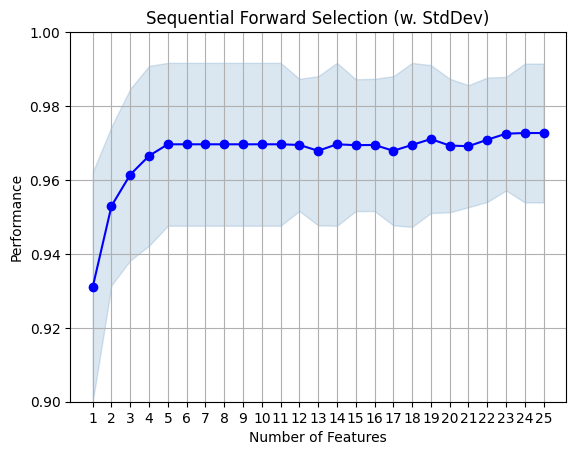

In [31]:
# Plot the results
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.9, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

Plotting the results we can see that performance begins to drop off after the 21st feature is added. Let's lock in those 21 features and use them to train our classifier. To be clear, these are not necessarily the first 21 features, but the 21 features which, when combined, produce optimal performance.

In [32]:
# Extract the feature names for the optimal number using the dictionary provided by the subsets_ method
columns = list(sfs.subsets_[21]['feature_idx'])

In [33]:
columns

[0, 1, 3, 4, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29]

Having determined which number of features was best, we'll select those specific features and train the model using only them. Remember, we need to select the features for both train _and_ test sets.

In [34]:
X_train_sfs = X_train[:, columns]
X_test_sfs = X_test[:, columns]

In [35]:
X_train_sfs.shape

(455, 21)

Now we can train the model on this reduced training set.

In [36]:
lm_sfs.fit(X_train_sfs, y_train)

LogisticRegression()

Finally, we'll generate some predictions.

In [37]:
pred_lm_sfs = lm_sfs.predict(X_test_sfs)

### Assessment

Using `classification report`, we'll look at F1 score, precision, and recall for each of our models.

In [38]:
print('Full Model')
print(classification_report(y_test, pred_lm_full, target_names=['Malignant', 'Benign']))

print('Var Thresh Model')
print(classification_report(y_test, pred_lm_vt, target_names=['Malignant', 'Benign']))

print('KBest Model')
print(classification_report(y_test, pred_lm_kbest, target_names=['Malignant', 'Benign']))

print('SFS Model')
print(classification_report(y_test, pred_lm_sfs, target_names=['Malignant', 'Benign']))

Full Model
              precision    recall  f1-score   support

   Malignant       1.00      1.00      1.00        39
      Benign       1.00      1.00      1.00        75

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114

Var Thresh Model
              precision    recall  f1-score   support

   Malignant       0.97      0.97      0.97        39
      Benign       0.99      0.99      0.99        75

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

KBest Model
              precision    recall  f1-score   support

   Malignant       1.00      1.00      1.00        39
      Benign       1.00      1.00      1.00        75

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00 

In [39]:
print('SFS Model')
print(classification_report(y_test, pred_lm_sfs, target_names=['Malignant', 'Benign']))

SFS Model
              precision    recall  f1-score   support

   Malignant       1.00      1.00      1.00        39
      Benign       1.00      1.00      1.00        75

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114



Interestingly, the full model achieves perfect accuracy in both classes, a 0.07% improvement over the full model in the previous train. The only difference here is that we scaled our data first – which clearly made a difference for the convergence of the logistic regression classifier.

The other three models all perform very well, with the `SelectKBest` model also achieving perfect accuracy in both classes. 

The variance thresholding model had the poorest performance of the four. Perhaps using variance alone was not a sufficient indicator of the importance of the features in question.

There is yet another method we can use to try and improve the model – let's take a look.

## 3. Tuning the model hyperparameter

Most models have settings or configuration values, known as hyperparameters, that can be changed to modify the fit of the model on the training data. The logistic regression model contains a hyperparameter _C_, which is used to control the penalty we apply to features that are less important (i.e. more important features will have greater weight).

The smaller the value of _C_, the greater the penalty to less important features. _C_ is a value greater than 0. You will recall from regression the regularisation methods Ridge and LASSO, which sought to minimise the L2- or L1-norm, respectively, by shrinking the coefficients of certain features. The penalty term had a coefficient of its own, which we called $\alpha$, which controlled the severity of shrinkage that occurred. The _C_ value we will change here is precisely the _inverse_ value of $\alpha$. In other words, the smaller the value of C, the greater the shrinkage that occurs.

### Training

We create three instances of the `LogisticRegression()` object, specifying a different value of the hyperparameter _C_ for each. When we set C to be small, we'll also specify the penalty type to be `l1` – this will allow some of the coefficients to be shrunk all the way to zero.

In [40]:
# Small C
model_1 = LogisticRegression(C=0.05, penalty='l1', solver='liblinear', verbose=1)

# Default C
model_2 = LogisticRegression(C=1)

# Large C
model_3 = LogisticRegression(C=10)

In [41]:
model_1.fit(X_train, y_train)

[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 8
iter   3  #CD cycles 1
iter   4  #CD cycles 5
iter   5  #CD cycles 11
iter   6  #CD cycles 1
iter   7  #CD cycles 3
iter   8  #CD cycles 3
iter   9  #CD cycles 2
iter  10  #CD cycles 1
iter  11  #CD cycles 2
iter  12  #CD cycles 2
iter  13  #CD cycles 1
iter  14  #CD cycles 4
iter  15  #CD cycles 4
iter  16  #CD cycles 2
iter  17  #CD cycles 1
iter  18  #CD cycles 3
iter  19  #CD cycles 2
iter  20  #CD cycles 1
iter  21  #CD cycles 2
iter  22  #CD cycles 2
iter  23  #CD cycles 2
optimization finished, #iter = 23
Objective value = 14.923299
#nonzeros/#features = 2/31


LogisticRegression(C=0.05, penalty='l1', solver='liblinear', verbose=1)

In [42]:
model_2.fit(X_train, y_train)

LogisticRegression(C=1)

In [43]:
model_3.fit(X_train, y_train)

LogisticRegression(C=10)

Taking a look at the magnitudes of the coefficients of each trained model, we can see that the smaller C is, the more features are shrunk. In the case where `penalty='l1'`, smaller C values literally mean fewer features are included. Notice how only one non-zero coefficient remains in that case.

In [44]:
model_1.coef_

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -2.07186779,  0.        ,  0.        ]])

In [45]:
model_2.coef_

array([[-1.75930064, -1.64894699, -1.71911997, -1.49738718, -0.47812622,
        -0.25483993, -1.39461047, -1.88715899, -0.3765542 ,  0.92764801,
        -1.15145058, -0.06103534, -0.87121041, -0.75335056, -0.05873744,
         0.67416552,  0.07505993, -0.35164235,  0.44691551,  0.57127994,
        -2.18825325, -2.22121697, -2.01394764, -1.58979978, -1.37800052,
        -0.73330044, -1.45134527, -2.49756936, -1.12521853, -0.30444925]])

In [46]:
model_3.coef_

array([[-2.47698413, -3.29766838, -2.36009471, -2.45654457, -0.91942132,
         1.36260736, -2.89647159, -3.65734995,  0.06006976,  1.89942543,
        -4.65053952, -0.22714002, -3.26171166, -2.62306583, -0.67412069,
         3.37482478,  0.2937626 , -0.7994922 ,  2.42401466,  1.99139459,
        -4.53183383, -4.8162922 , -3.91003277, -3.51994646, -3.05255678,
        -0.38599861, -3.21201043, -3.83851487, -2.75861462, -0.90627326]])

### Predicting

The models have been trained. Let's make some predictions.

In [47]:
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)

### Testing

We will once again use the classification report to compare the model results. 

In [48]:
print('C = 0.05')
print(classification_report(y_test, pred_1, target_names=['Malignant', 'Benign']))

print('C = 1')
print(classification_report(y_test, pred_2, target_names=['Malignant', 'Benign']))

print('C = 10')
print(classification_report(y_test, pred_3, target_names=['Malignant', 'Benign']))

C = 0.05
              precision    recall  f1-score   support

   Malignant       0.96      0.62      0.75        39
      Benign       0.83      0.99      0.90        75

    accuracy                           0.86       114
   macro avg       0.90      0.80      0.83       114
weighted avg       0.88      0.86      0.85       114

C = 1
              precision    recall  f1-score   support

   Malignant       1.00      1.00      1.00        39
      Benign       1.00      1.00      1.00        75

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114

C = 10
              precision    recall  f1-score   support

   Malignant       0.97      0.97      0.97        39
      Benign       0.99      0.99      0.99        75

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       11

Clearly, in setting C = 0.05 we have tuned the hyperparameter too aggressively and adversely affected the model's performance. Note how the F1 score is significantly lower for that variation than any other we have looked at.

The logistic regression algorithm is a simple case for hyperparameter tuning because it only contains one value to tweak. Other models, like support vector machines, tree-based methods, and neural networks, contain many more hyperparameters – in most cases too many for the model architect to optimise on their own. In these cases, we use what is known as grid search: an iterative testing of multiple combinations of hyperparameters to find the optimal set. More on that later on.

## Conclusion

In this train, we have seen or been introduced to:

- The importance of carrying out a train/test split before doing any feature selection.
- Feature subset selection by variance thresholding.
- Feature subset selection by selecting the k-best features.
- Feature subset selection by sequential forward selection.
- Improving a model by tuning the hyperparameters.

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>